<a href="https://colab.research.google.com/github/MrFlygerian/data-science-portfolio/blob/master/Blessed_Image_Novoic_ML_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___This is Blessed Chianumba's attempt at the Novoic ML challenge. An ongoing project.___

## Data retrieval
Copying the dataset to local directory (runtime ~ 10 minutes)*italicized text*

In [2]:
%%time

!mkdir -p data
!gsutil -m cp -r gs://novoic-ml-challenge-image-data/* ./data

Streaming output truncated to the last 5000 lines.
Copying gs://novoic-ml-challenge-image-data/images/2011_001599.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001597.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001600.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001601.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001602.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001605.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001606.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001607.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001608.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001610.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001611.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001612.jpg...
Copying gs://novoic-ml-challenge-image-data/images/2011_001613.jpg...
Copying gs://novoic-ml-challenge-image-

## Data description

- 17,125 images (normal photographs taken with normal cameras) in jpg format.
- Each photograph is realistic (e.g. a bike on a road), meaning they all contain multiple objects with (usually) one subject. 
- There are 20 classes of interest: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, TV monitor.
- Each image is labelled with one of three numbers for each object class:
  - -1 (no objects of this class feature in the image)
  - 1 (at least one object of this class features in the image)
  - 0 (at least one object of this class features in the image but they are all difficult to recognise)



Example pic #1

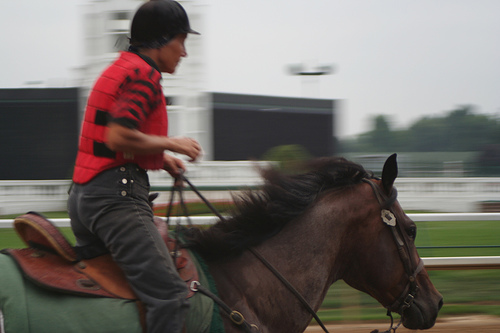

In [3]:
import IPython 
IPython.display.Image(filename='data/images/2012_004258.jpg') 

Example pic #2

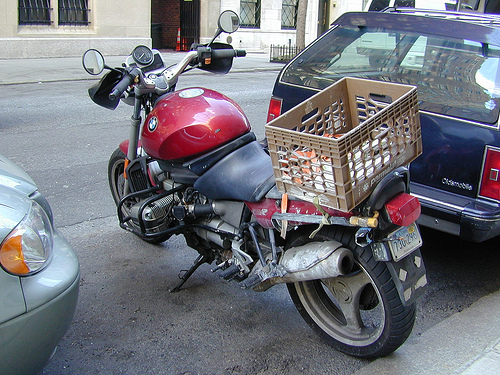

In [4]:
IPython.display.Image(filename='data/images/2008_007739.jpg')

Each object class file (e.g. `aeroplane.txt`) contains the name of the image without the extension (e.g. `2008_007739`) followed by a space and then the class label (e.g. `-1`).

For more information about the dataset, see the `README.md`.

Directory structure:
```
data/
├── images/         # dir for jpg files
├── aeroplane.txt   # aeroplane object class labels
├── bicycle.txt     # bicycle object class labels
├── bird.txt        # bird object class labels
├── boat.txt        # boat object class labels
├── bottle.txt      # bottle object class labels
├── bus.txt         # bus object class labels
├── car.txt         # car object class labels
├── cat.txt         # cat object class labels
├── chair.txt       # chair object class labels
├── cow.txt         # cow object class labels
├── diningtable.txt # dining table object class labels
├── dog.txt         # dog object class labels
├── horse.txt       # horse object class labels
├── motorbike.txt   # motorbike object class labels
├── person.txt      # person object class labels
├── pottedplant.txt # potted plant object class labels
├── sheep.txt       # sheep object class labels
├── sofa.txt        # sofa object class labels
├── train.txt       # train object class labels
├── tvmonitor.txt   # TV monitor object class labels
├── LICENSE
└── README.md
```






### Imports

In [5]:
from numpy.random import seed
seed(888)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(404)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
import keras.applications
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model

import pickle



### Constants

In [14]:
DATA_DIR = 'data/'
IMAGE_DIR = 'data/images/'
LOG_DIR = 'tb_novoic_image_logs'

TXT_FNAMES = glob.glob(DATA_DIR + '*.txt')

VALID_SIZE = 100
BATCH_SIZE = 200  # Major factor in if the models actually run; larger batch sizes result in OOM error as resource runs out
EPOCHS = 50
IMG_SIZE = 256


## Data Preperation

Our data is in an odd format atm. Let's change it in to a form that keras can understand for augmentation and training. 

In [15]:
sample_df = pd.read_csv(TXT_FNAMES[0], header=None, sep='\s+' )

In [16]:
sample_df.head()

,0,1
0,2008_000002,-1
1,2008_000003,1
2,2008_000007,-1
3,2008_000008,1
4,2008_000009,-1


In [17]:
frames = []

for name in TXT_FNAMES:
    frames.append(pd.read_csv(name, header=None, sep='\s+' ))

df = pd.concat(frames, axis=1)

cols = [re.findall(r'[ \w-]+?(?=\.)',fname) for fname in TXT_FNAMES]
cols = [item for fname in cols for item in fname]

df.index=df.iloc[:,0]
df.index = df.index +'.jpg'
df.index.name = 'image_file_path'
df = df.drop(columns=0)
df.columns = cols
df.reset_index(inplace=True)
df[df.columns[1:]]= df[df.columns[1:]].astype(float)


In [18]:
df.head()

,image_file_path,person,aeroplane,horse,bird,cow,bottle,pottedplant,bicycle,diningtable,bus,car,motorbike,chair,dog,sheep,sofa,train,boat,tvmonitor,cat
0,2008_000002.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
1,2008_000003.jpg,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,2008_000007.jpg,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
3,2008_000008.jpg,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2008_000009.jpg,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [19]:
df.shape

(11540, 21)

## Image modelling with Keras

We'll use keras to create and train our models with imagenet weights for transfer learning. Tensorboard will help us to see how our models are doing, and Early Stopping will terminate our training if the validation score doesn't imprve after a while.

In [20]:
"""Only required if there is a dedicated GPU available"""
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [21]:
# reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change as required
    except:
        pass

    # use the same used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    
reset_keras()

In [22]:
# Split original dataframe
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[:-VALID_SIZE], test_size = 0.25)
print('train data shape:', train.shape, '\ntest data shape:', test.shape)


train data shape: (8580, 21) 
test data shape: (2860, 21)


In [23]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [24]:
train_set=datagen.flow_from_dataframe(
    dataframe=train,
    directory=IMAGE_DIR,  
    x_col='image_file_path', 
    y_col=train.columns[1:],
    batch_size=BATCH_SIZE, 
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(IMG_SIZE,IMG_SIZE))

Found 8580 validated image filenames.


In [25]:
test_set = datagen.flow_from_dataframe(
    dataframe=test,
    directory=IMAGE_DIR,
    x_col='image_file_path',
    y_col=test.columns[1:],
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE,IMG_SIZE)
)

Found 2860 validated image filenames.


In [26]:
output_layer = len(train.columns[1:])
print(output_layer)

20


In [27]:
# functions for building models, running models and custom callbacks

# Buidling models
def build_model(architecture):
  model = Sequential()

  if architecture == 'VGG19':
    print('Using VGG19')
    model.add(keras.applications.vgg19.VGG19(weights='imagenet', include_top=False,
                                             input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')))
    model.add(Flatten(name='flatten'))
    model.add(Dense(1000, activation='relu', name='fc1'))
    model.add(Dense(1000, activation='relu', name='fc2'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))

  elif architecture == 'InceptionResNetV2':
    print('Using InceptionResNetV2')
    model.add(tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False,
                                                      input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')))
    model.add(tf.keras.layers.Conv2D(filters=3000, kernel_size=(2,2),
                                     kernel_initializer='he_uniform', padding='same', activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))

  else:
    print('Using ResNet50')
    model.add(keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                   input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE, 3), name='input')))
    model.add(tf.keras.layers.Conv2D(filters=3000, kernel_size=(2,2),
                                     kernel_initializer='he_uniform', padding='same', activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(output_layer, activation='softmax', name='predictions'))
    
  model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    
    
  return model

# custom callback(s)
def get_TB(name):
    

    folder_name = f'{name}_logs'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print (err.strerror)
    else:
        print ('made directory')

    return TensorBoard(log_dir=dir_paths, profile_batch=2, write_graph=True,
                       histogram_freq=1, embeddings_freq=1 )


# running models
def run_model(model, name):
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)
  tb = TensorBoard(log_dir=f'./{name}_logs', profile_batch=2, embeddings_freq=1, histogram_freq=1)

  history = model.fit(x = train_set, validation_data = test_set, epochs = EPOCHS, callbacks=[es, get_TB(name)])
  model.save(f'test_{name}.h5')
  with open(f'test_history_{name}', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
  
  model.summary()

  return history


In [ ]:
%%time

# Build and run InceptionResNetV2 Model
Inception_ResNet_model = build_model('InceptionResNetV2')
IR_history = run_model(Inception_ResNet_model, 'IR_model')

# Build and run VGG19 Model
VGG19_model = build_model('VGG19')
VGG19_history = run_model(VGG19_model, 'VGG19_model')

# Build and run ResNet Model
ResNet_model = build_model('ResNet')
ResNet_history = run_model(ResNet_model, 'ResNet_model')




Using InceptionResNetV2
219062272/219055592 [==============================] - 4s 0us/step
made directory
Epoch 1/50


####_Visualise training_ 

In [ ]:
# Get a visual on the model performance and structure. Commment/uncomment load and reload commands as needed

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir /tb_novoic_image_logs

## Making Predictions

Lets see how well our models do on data that hasn't already been seen.

In [ ]:
validation = df.iloc[-VALID_SIZE:]

In [ ]:
# Retrieve holdout set for real validation

holdout_set = datagen.flow_from_dataframe(
    dataframe=validation,
    directory=IMAGE_DIR,
    x_col='image_file_path',
    y_col=test.columns[1:],
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(IMG_SIZE,IMG_SIZE))

In [ ]:
# display a few images 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

print('first 3 images of the holdout set')
for i in range(0,3):
    process(IMAGE_DIR + validation.iloc[i,0])

### Measure accuracy of models

In [ ]:
# function for testing model (validation data should be a var too)
def test_model(model_file_path, name, validation_dataset):
  model = load_model(model_file_path)

  pred_labels = np.argmax(model.predict(validation_dataset), axis = 1)
  pred_classes = [cols[i] for i in pred_labels]
  print('Predicted dominant image feature for the first 3 images: ', pred_classes[:3])
  acca = sum(np.equal(true_labels, pred_labels)) / len(true_labels)
  print(f"Accuracy of model {name}: {acca:.0%} " )

  return acca

In [ ]:
# function for getting model history
def get_model_history(history_file_path):
  with open(history_file_path, 'rb') as file:
    history=pickle.load(file)
  
  return history

In [ ]:
true_labels = np.argmax(holdout_set.labels, axis = 1)
true_classes = [cols[i] for i in true_labels]

print('Most dominant image feature for the first 3 images: ', true_classes[:3])

In [ ]:
ResNet_acca = test_model('test_ResNet_model.h5','ResNet', holdout_set)
VGG19_acca = test_model('test_VGG19_model.h5', 'VGG19', holdout_set)
IR_acca = test_model('test_IR_model.h5', 'InceptionResNet',holdout_set)

In [ ]:
IR_history = get_model_history('test_history_IR_model')
VGG19_history = get_model_history('test_history_VGG19_model')
ResNet_history = get_model_history('test_history_ResNet_model')

In [ ]:
def plot_history_metrics(history_object, colour):
  for i, ax in enumerate(fig.axes):
    ax.plot(range(0,len(history_object[list(history_object.keys())[i]])),
            history_object[list(history_object.keys())[i]], color = colour)
    ax.set_xlabel('Epoch', fontsize = 13)
    ax.set_ylabel(list(history_object.keys())[i], fontsize = 13)

### Display history metrics with matplotlib

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (15,10))
fig.suptitle('Model Metrics', fontsize=20)
plt.tight_layout(pad = 5)

plot_history_metrics(IR_history, 'r')
plot_history_metrics(ResNet_history,'b')
plot_history_metrics(VGG19_history, 'g')
